#Création et la Reproduction de Style Caricatural via StableDiffusion, et la Détection des Artefacts Visuels (Évaluation de la Qualité de Génération).


##Installation

In [ ]:
!pip install opencv-python
!pip install numpy
!pip install scikit-learn
!pip install transformers
!pip install huggingface-hub
!pip install git+https://github.com/facebookresearch/detectron2.git
!pip install albumentations
!pip install torch torchvision

#Training

## Importation des Bibliothèques
Nous commençons par importer les bibliothèques nécessaires pour notre projet.

Ces bibliothèques incluent des outils pour la manipulation des données, la création de modèles de détection d'objets et la visualisation des résultats.

## Définition de la Classe `ArtifactDataset`
Nous définissons une classe `ArtifactDataset` qui hérite de `torch.utils.data.Dataset`. Cette classe est utilisée pour charger et prétraiter les images et annotations.

### Initialisation de la Classe
Le constructeur `__init__` initialise les variables et traite les annotations pour extraire les boîtes englobantes et les classes des objets dans les images.

### Taille du Dataset
La méthode `__len__` renvoie le nombre total d'images dans le dataset.

### Récupération d'un Échantillon
La méthode `__getitem__` charge une image et ses annotations correspondantes. Elle applique également des transformations aux images et aux boîtes englobantes si elles sont définies.

### Transformation des Images et des Boîtes
La méthode `transform_image_and_boxes` redimensionne les images et ajuste les boîtes englobantes en conséquence.


In [ ]:
import os
import json
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import generalized_box_iou_loss
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split

class ArtifactDataset(Dataset):
    def __init__(self, annotations, img_dir, transform=None, min_box_area=100):
        self.img_labels = {}
        self.img_classes = {}
        for ann in annotations:
            path = ann['path_name']
            if path not in self.img_labels:
                self.img_labels[path] = []
                self.img_classes[path] = ann['label']
            if ann['coordinates'] is not None:
                x, y, w, h = ann["coordinates"]
                x_min, y_min, x_max, y_max = x, y, x + w, y + h
                box_area = w * h
                if box_area >= min_box_area:
                    self.img_labels[path].append([x_min, y_min, x_max, y_max])
        self.img_dir = img_dir
        self.transform = transform
        self.image_paths = list(self.img_labels.keys())

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_paths[idx])
        image = Image.open(img_path).convert("RGB")
        boxes = self.img_labels[self.image_paths[idx]]

        if self.transform:
            image, boxes = self.transform_image_and_boxes(image, boxes)

        boxes = torch.tensor(boxes, dtype=torch.float32)
        if self.img_classes[self.image_paths[idx]] == "artifact":
            labels = torch.ones((boxes.size(0),), dtype=torch.int64)  # Artifact class = 1
        else:
            labels = torch.zeros((boxes.size(0),), dtype=torch.int64)  # No artifact class = 0

        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)

        areas = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx]),
            "area": areas,
            "iscrowd": torch.zeros((boxes.size(0),), dtype=torch.int64)
        }
        return image, target

    def transform_image_and_boxes(self, image, boxes):
        original_width, original_height = image.size
        transformed_image = self.transform(image)

        if isinstance(transformed_image, torch.Tensor):
            new_width = transformed_image.shape[2]
            new_height = transformed_image.shape[1]
        else:
            new_width, new_height = transformed_image.size

        scaled_boxes = []
        for box in boxes:
            x_min, y_min, x_max, y_max = box
            scaled_x_min = x_min * (new_width / original_width)
            scaled_y_min = y_min * (new_height / original_height)
            scaled_x_max = x_max * (new_width / original_width)
            scaled_y_max = y_max * (new_height / original_height)
            scaled_boxes.append([scaled_x_min, scaled_y_min, scaled_x_max, scaled_y_max])

        return transformed_image, scaled_boxes


## Chemins des Fichiers

Nous définissons les chemins des fichiers pour les images, les annotations et le modèle. Les chemins peuvent être ajustés pour un environnement Google Drive ou un environnement local.

## Affichage des Images avec Boîtes Englobantes

La fonction `display_image_with_boxes` permet d'afficher une image avec ses boîtes englobantes pour visualiser les artefacts détectés. Elle utilise Matplotlib pour tracer les boîtes sur l'image.

## Chargement des Annotations

Nous chargeons les annotations à partir du fichier JSON spécifié. Ces annotations contiennent les informations nécessaires pour chaque image, y compris les coordonnées des boîtes englobantes et les étiquettes des classes.

## Séparation des Données

Nous divisons les chemins des images en ensembles d'entraînement, de validation et de test. Cette séparation permet de former, valider et tester le modèle de manière appropriée.

## Filtrage des Annotations

Les annotations sont filtrées en fonction des ensembles de données d'entraînement, de validation et de test. Cela garantit que chaque ensemble contient les annotations correctes pour les images qu'il contient.

## Transformation des Images

Nous définissons des transformations pour redimensionner les images à une taille fixe et les convertir en tenseurs. Ces transformations sont appliquées lors du chargement des données.

## Création des Datasets

Nous créons les datasets pour l'entraînement, la validation et le test en utilisant les annotations filtrées et les transformations définies.

## Chargement des Données

Nous utilisons `DataLoader` pour charger les données des datasets en lots. Cela permet un traitement efficace des données pendant l'entraînement et l'évaluation.

## Définition du Modèle de Détection d'Objets

La fonction `get_object_detection_model` définit et renvoie un modèle de détection d'objets basé sur Faster R-CNN avec un backbone ResNet-50. Nous modifions le prédicteur pour correspondre au nombre de classes de notre dataset et utilisons une perte de régression de boîte basée sur le Generalized IoU.


In [ ]:
# Drive paths
# image_dir = "/content/drive/MyDrive/Master 2/augmented_base"
# annotation_path = "/content/drive/MyDrive/Master 2/annotations.json"
# model_path = "/content/drive/MyDrive/Master 2/artifact_detection_model.pth"

# Local paths
image_dir = "./Data"
annotation_path = "./Data/annotations.json"
model_path = "./artifact_detection_model_2.pth"

def display_image_with_boxes(image, boxes, title):
    fig, ax = plt.subplots(1)
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0)
    ax.imshow(image)
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.title(title)
    plt.show()
with open(annotation_path, 'r') as f:
    annotations = json.load(f)

image_paths = list(set(annotation['path_name'] for annotation in annotations))
train_paths, test_paths = train_test_split(image_paths, test_size=0.1, random_state=42)
train_paths, val_paths = train_test_split(train_paths, test_size=0.2, random_state=42)

# print("*****")
# print(train_paths)
# print(test_paths)
# print(val_paths)
# print("*****")

train_annotations = [ann for ann in annotations if ann['path_name'] in train_paths]
val_annotations = [ann for ann in annotations if ann['path_name'] in val_paths]
test_annotations = [ann for ann in annotations if ann['path_name'] in test_paths]

# print("*****")
# print(train_annotations)
# print(val_annotations)
# print(test_annotations)
# print("*****")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = ArtifactDataset(train_annotations, img_dir=image_dir, transform=transform)
val_dataset = ArtifactDataset(val_annotations, img_dir=image_dir, transform=transform)
test_dataset = ArtifactDataset(test_annotations, img_dir=image_dir, transform=transform)

batch_size = 24
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

def get_object_detection_model(num_classes):
    model = models.detection.fasterrcnn_resnet50_fpn(weights='COCO_V1')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.roi_heads.loss_box_reg = generalized_box_iou_loss  # Modify the box regression loss to use Generalized IoU
    return model

model = get_object_detection_model(num_classes=2)

print("********************************************")
print(f"Train size: {len(train_annotations)}")
print(f"Validation size: {len(val_annotations)}")
print(f"Test size: {len(test_annotations)}")
print("********************************************")

********************************************
Train size: 4691
Validation size: 1234
Test size: 741
********************************************


In [ ]:
import random
def display_sample_images(data_loader, num_samples=5):
    sampled_images = random.sample(list(data_loader), num_samples)
    for images, targets in sampled_images:
        for image, target in zip(images, targets):
            print( target)
            display_image_with_boxes(image, target['boxes'], title="Image with Artifacts")
display_sample_images(train_loader)

## Configuration du Dispositif

Nous déterminons si un GPU est disponible et définissons le modèle pour qu'il utilise le GPU si possible. Cela permet d'accélérer les calculs pendant l'entraînement et l'évaluation du modèle.

## Configuration de l'Optimiseur et du Scheduler

Nous configurons l'optimiseur AdamW pour mettre à jour les poids du modèle avec une certaine valeur de learning rate et de weight decay. Un scheduler est également configuré pour réduire le learning rate lorsque la performance du modèle stagne.

## Définition de la Fonction pour le Remplissage des Boîtes

La fonction `pad_boxes` est utilisée pour compléter les listes de boîtes englobantes avec des boîtes factices pour atteindre une taille maximale spécifiée. Cela est utile pour la comparaison entre les prédictions et les boîtes réelles.

## Boucle d'Entraînement

Nous entrons dans la boucle d'entraînement pour un certain nombre d'époques. Pendant chaque époque, le modèle est entraîné sur les lots d'images et de cibles :

- Le modèle calcule les pertes pour chaque lot, et ces pertes sont ensuite cumulées pour obtenir une perte totale d'entraînement.
- Les gradients sont calculés et les paramètres du modèle sont mis à jour en conséquence.
- Des informations sur la progression de l'entraînement sont affichées périodiquement.

## Évaluation du Modèle

Après chaque époque d'entraînement, le modèle est évalué sur le jeu de validation :

- Le modèle passe en mode évaluation pour désactiver le calcul des gradients.
- Les prédictions du modèle sont obtenues pour chaque image.
- Les boîtes prédictives sont filtrées en fonction d'un seuil de confiance et sont soumises à une suppression non maximale (NMS) pour éliminer les chevauchements excessifs.
- Les boîtes prédictives et les boîtes cibles sont complétées pour être de la même taille, puis une perte de boîte généralisée (Generalized IoU) est calculée.
- La perte moyenne de validation est calculée et affichée.

## Mise à Jour du Learning Rate

Le scheduler ajuste le learning rate en fonction de la performance du modèle sur le jeu de validation.

## Enregistrement du Modèle

À la fin de l'entraînement, les poids du modèle sont sauvegardés dans le fichier spécifié. Cela permet de réutiliser le modèle entraîné sans avoir à le réentraîner à partir de zéro.


In [ ]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.ops import generalized_box_iou_loss, nms, box_iou

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=3e-4, weight_decay=1e-4)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, verbose=True)

num_epochs = 20

def pad_boxes(boxes, max_boxes):
    padding_size = max_boxes - len(boxes)
    if padding_size > 0:
        padded_boxes = torch.cat([boxes, torch.zeros((padding_size, 4), device=boxes.device)], dim=0)
    else:
        padded_boxes = boxes
    return padded_boxes

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for i, (images, targets) in enumerate(train_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        train_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_loader)}], Loss: {losses.item():.4f}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss / len(train_loader):.4f}")

    model.eval()
    val_loss = 0
    num_batches = 0

    with torch.no_grad():
        for images, targets in val_loader:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            for i in range(len(images)):
                true_boxes = targets[i]['boxes'].to(device)
                pred_boxes = outputs[i]['boxes'].to(device)
                pred_scores = outputs[i]['scores'].to(device)

                confidence_threshold = 0.4
                high_conf_indices = pred_scores > confidence_threshold
                pred_boxes = pred_boxes[high_conf_indices]
                pred_scores = pred_scores[high_conf_indices]

                if pred_boxes.numel() == 0 or true_boxes.numel() == 0:
                    continue

                keep = nms(pred_boxes, pred_scores, iou_threshold=0.5)
                pred_boxes = pred_boxes[keep]
                pred_scores = pred_scores[keep]

                if pred_boxes.numel() == 0 or true_boxes.numel() == 0:
                    continue

                max_boxes = max(pred_boxes.shape[0], true_boxes.shape[0])
                output_boxes_padded = pad_boxes(pred_boxes, max_boxes)
                target_boxes_padded = pad_boxes(true_boxes, max_boxes)

                if output_boxes_padded.size(0) > 0 and target_boxes_padded.size(0) > 0:
                    loss_giou = generalized_box_iou_loss(output_boxes_padded, target_boxes_padded)
                    val_loss += loss_giou.mean().item()
                    num_batches += 1

    avg_val_loss = val_loss / num_batches if num_batches > 0 else 0

    print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}")

    lr_scheduler.step(avg_val_loss)

print("Training complete.")
torch.save(model.state_dict(), model_path)
print("Model saved.")

/home/ubuntu/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/20], Step [0/71], Loss: 1.1309
Epoch [1/20], Step [10/71], Loss: 0.5472
Epoch [1/20], Step [20/71], Loss: 0.4586
Epoch [1/20], Step [30/71], Loss: 0.7829
Epoch [1/20], Step [40/71], Loss: 0.5329
Epoch [1/20], Step [50/71], Loss: 0.6052
Epoch [1/20], Step [60/71], Loss: 0.4723
Epoch [1/20], Step [70/71], Loss: 0.5868
Epoch [1/20], Train Loss: 0.5862
Epoch [1/20], Val Loss: 1.5595
Epoch [2/20], Step [0/71], Loss: 0.5207
Epoch [2/20], Step [10/71], Loss: 0.4044
Epoch [2/20], Step [20/71], Loss: 0.6039
Epoch [2/20], Step [30/71], Loss: 0.4049
Epoch [2/20], Step [40/71], Loss: 0.5227
Epoch [2/20], Step [50/71], Loss: 0.5355
Epoch [2/20], Step [60/71], Loss: 0.6080
Epoch [2/20], Step [70/71], Loss: 0.4963
Epoch [2/20], Train Loss: 0.5069
Epoch [2/20], Val Loss: 1.4497
Epoch [3/20], Step [0/71], Loss: 0.3393
Epoch [3/20], Step [10/71], Loss: 0.4988
Epoch [3/20], Step [20/71], Loss: 0.4254
Epoch [3/20], Step [30/71], Loss: 0.4178
Epoch [3/20], Step [40/71], Loss: 0.4993
Epoch [3/20], 

## Chargement du model entrainé

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.load_state_dict(torch.load(model_path))
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Affichage des Images avec Boîtes Englobantes

La fonction `display_image_with_boxes` permet d'afficher une image avec ses boîtes englobantes réelles et prédites. Cette fonction utilise Matplotlib pour tracer les boîtes sur l'image.

### Processus de la Fonction

1. **Affichage de l'Image** : L'image est affichée en utilisant Matplotlib.
2. **Boîtes Réelles** : Les boîtes englobantes réelles (`true_boxes`) sont tracées en vert.
3. **Suppression Non Maximale (NMS)** : Les boîtes prédites (`pred_boxes`) et les scores associés (`pred_scores`) sont filtrées à l'aide de la suppression non maximale pour éliminer les chevauchements excessifs.
4. **Boîtes Prédites** : Les boîtes englobantes prédites, qui ont un score supérieur ou égal à un seuil de confiance spécifié, sont tracées en rouge.


## Affichage des Résultats

Pour chaque image du lot, les boîtes réelles et prédites sont extraites et passées à la fonction `display_image_with_boxes` pour être affichées avec leurs annotations respectives.


In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.ops import box_iou, nms

def display_image_with_boxes(image, true_boxes, pred_boxes, pred_scores, confidence_threshold=0.6, iou_threshold=0.2):
    fig, ax = plt.subplots(1)
    ax.imshow(image.permute(1, 2, 0))
    for box in true_boxes:
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
    keep = nms(torch.tensor(pred_boxes), torch.tensor(pred_scores), iou_threshold)
    for idx in keep:
        box = pred_boxes[idx]
        score = pred_scores[idx]
        if score >= confidence_threshold:
            rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
    plt.show()
images, targets = next(iter(test_loader))
images = list(img.to(device) for img in images)

model.eval()
with torch.no_grad():
    outputs = model(images)

for i in range(len(images)):
    image = images[i].cpu()
    true_boxes = targets[i]['boxes'].cpu().numpy()
    pred_boxes = outputs[i]['boxes'].cpu().numpy()
    pred_scores = outputs[i]['scores'].cpu().numpy()
    display_image_with_boxes(image, true_boxes, pred_boxes, pred_scores)

## Définition des Seuils

Nous définissons des seuils pour la confiance (`confidence_threshold`), l'IoU (`iou_threshold`) et le taux de contenance (`containment_threshold`).

Ces seuils déterminent quelles boîtes prédictives sont considérées comme positives.

## Calcul des Métriques

### Précision et Rappel

Les fonctions de calcul de précision et de rappel déterminent respectivement la proportion de prédictions correctes parmi les prédictions totales et la proportion de véritables positifs détectés parmi les positifs réels.

- **Précision**: \(\text{Précision} = \frac{TP}{TP + FP}\)

- **Rappel**: \(\text{Rappel} = \frac{TP}{TP + FN}\)

### F1 Score

Le F1 score est la moyenne harmonique de la précision et du rappel, offrant un équilibre entre les deux.

- **F1 Score**: \(F1 = 2 \times \frac{\text{Précision} \times \text{Rappel}}{\text{Précision} + \text{Rappel}}\)

### Exactitude

L'exactitude est le rapport entre les véritables positifs et la somme des véritables positifs, faux positifs et faux négatifs.

- **Exactitude**: \(\text{Exactitude} = \frac{TP}{TP + FP + FN}\)

### Contenance

La fonction de contenance vérifie si une boîte prédictive est principalement contenue dans une boîte réelle, selon un seuil de contenance spécifié.

- **Contenance**: \(\text{Contenance} = \frac{\text{aire de l'intersection}}{\text{aire de la boîte réelle}}\)

## Calcul des Métriques sur les Boîtes

La fonction `calculate_metrics` calcule les métriques de performance des boîtes prédictives par rapport aux boîtes réelles. Elle retourne la précision, le rappel, le F1 score, l'exactitude, l'IoU moyen, et des détails sur chaque prédiction.

## Évaluation du Modèle sur l'Ensemble de Test

La fonction `evaluate_model_on_test_set` évalue le modèle sur l'ensemble de test. Elle calcule les métriques globales de performance (précision, rappel, F1 score, exactitude, IoU moyen) en agrégeant les résultats de chaque image du test.

### Processus d'Évaluation

1. **Mode Évaluation** : Le modèle est mis en mode évaluation.
2. **Prédictions et Filtrage** : Les prédictions sont obtenues pour chaque image et filtrées en fonction du seuil de confiance. Les prédictions sont également soumises à la suppression non maximale (NMS) pour éliminer les boîtes redondantes.
3. **Calcul des Métriques** : Les métriques sont calculées pour chaque paire d'image et de boîtes réelles/prédictives.
4. **Agrégation des Résultats** : Les métriques globales sont calculées en agrégeant les résultats de toutes les images.

## Affichage des Résultats

Les résultats des métriques globales (précision, rappel, F1 score, exactitude, IoU moyen) sont affichés, offrant une vue d'ensemble des performances du modèle sur l'ensemble de test. Les détails des prédictions pour chaque image sont également imprimés pour une analyse plus approfondie.


In [ ]:
import torch
from torchvision.ops import box_iou, nms

CONFIDENCE_THRESHOLD = 0.5
IOU_THRESHOLD = 0.5
CONTAINMENT_THRESHOLD = 0.8

def calculate_precision_recall(tp, fp, fn):
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    return precision, recall

def calculate_f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

def calculate_accuracy(tp, fp, fn):
    return tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0

def is_contained(pred_box, gt_box, threshold=CONTAINMENT_THRESHOLD):
    x1 = max(pred_box[0], gt_box[0])
    y1 = max(pred_box[1], gt_box[1])
    x2 = min(pred_box[2], gt_box[2])
    y2 = min(pred_box[3], gt_box[3])

    if x1 >= x2 or y1 >= y2:
        return False

    intersection_area = (x2 - x1) * (y2 - y1)
    pred_box_area = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    return (intersection_area / pred_box_area) >= threshold

def calculate_metrics(pred_boxes, true_boxes, iou_threshold=IOU_THRESHOLD):
    if pred_boxes.numel() == 0 and true_boxes.numel() == 0:
        return 1, 1, 1, 1, 0, []

    if pred_boxes.numel() == 0:
        return 0, 0, 0, 0, 0, [("FN", box.tolist(), f'GT{i}') for i, box in enumerate(true_boxes)]

    if true_boxes.numel() == 0:
        return 0, 0, 0, 0, 0, [("FP", box.tolist(), f'P{i}') for i, box in enumerate(pred_boxes)]

    ious = box_iou(pred_boxes, true_boxes)
    tp = 0
    fp = 0
    fn = 0
    details = []
    matched_gt = set()
    total_iou = 0
    matched_boxes_count = 0

    for i in range(len(pred_boxes)):
        max_iou, max_idx = ious[i].max(0) if ious[i].numel() > 0 else (torch.tensor(0), torch.tensor(0))
        contained_80 = any(is_contained(pred_boxes[i], true_boxes[j], threshold=CONTAINMENT_THRESHOLD) for j in range(len(true_boxes)))

        if max_iou >= iou_threshold or contained_80:
            if max_idx.item() not in matched_gt:
                tp += 1
                matched_gt.add(max_idx.item())
                total_iou += max_iou.item()
                matched_boxes_count += 1
            details.append(("TP: Pred Box {} -> GT Box {} with IoU {:.2f}".format(i, max_idx.item(), max_iou.item()), pred_boxes[i].tolist(), f'GT{max_idx.item()}'))
        else:
            fp += 1
            details.append(("FP: Pred Box {} with IoU {:.2f}".format(i, max_iou.item()), pred_boxes[i].tolist(), f'P{i}'))

    for j in range(len(true_boxes)):
        if ious[:, j].max().item() < iou_threshold and not any(is_contained(pred_boxes[i], true_boxes[j], threshold=CONTAINMENT_THRESHOLD) for i in range(len(pred_boxes))):
            fn += 1
            details.append(("FN: GT Box {} missed".format(j), true_boxes[j].tolist(), f'GT{j}'))

    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    accuracy = tp / (tp + fp + fn) if tp + fp + fn > 0 else 0
    mean_iou = total_iou / matched_boxes_count if matched_boxes_count > 0 else 0

    return precision, recall, f1_score, accuracy, mean_iou, details

def evaluate_model_on_test_set(test_loader, model, device, confidence_threshold=CONFIDENCE_THRESHOLD):
    tp = 0
    fp = 0
    fn = 0
    total_iou = 0
    matched_boxes_count = 0
    detailed_outputs = []

    model.eval()
    with torch.no_grad():
        for images, targets in test_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)
            for i in range(len(images)):
                true_boxes = targets[i]['boxes'].to(device)
                pred_boxes = outputs[i]['boxes'].to(device)
                pred_scores = outputs[i]['scores'].to(device)

                high_conf_indices = pred_scores > confidence_threshold

                pred_boxes = pred_boxes[high_conf_indices]
                pred_scores = pred_scores[high_conf_indices]

                if pred_boxes.numel() == 0:
                    fn += len(true_boxes)
                    detailed_outputs.extend([("FN", box.tolist(), f'GT{i}') for i, box in enumerate(true_boxes)])
                    continue

                if true_boxes.numel() == 0:
                    fp += len(pred_boxes)
                    detailed_outputs.extend([("FP", box.tolist(), f'P{i}') for i, box in enumerate(pred_boxes)])
                    continue

                keep = nms(pred_boxes, pred_scores, IOU_THRESHOLD)
                pred_boxes = pred_boxes[keep]
                pred_scores = pred_scores[keep]

                precision, recall, f1_score, accuracy, mean_iou, details = calculate_metrics(pred_boxes.cpu(), true_boxes.cpu())

                tp += precision * len(details)
                fp += (1 - precision) * len(details)
                fn += (1 - recall) * len(details)
                total_iou += mean_iou * len(details)
                matched_boxes_count += len(details)

                detailed_outputs.extend(details)

    global_precision = tp / (tp + fp) if tp + fp > 0 else 0
    global_recall = tp / (tp + fn) if tp + fn > 0 else 0
    global_f1_score = 2 * (global_precision * global_recall) / (global_precision + global_recall) if global_precision + global_recall > 0 else 0
    global_accuracy = tp / (tp + fp + fn) if tp + fp + fn > 0 else 0
    global_mean_iou = total_iou / matched_boxes_count if matched_boxes_count > 0 else 0

    for detail in detailed_outputs:
        print(detail[0], detail[1], detail[2])

    return global_precision, global_recall, global_f1_score, global_accuracy, global_mean_iou

precision, recall, f1_score, accuracy, mean_iou = evaluate_model_on_test_set(test_loader, model, device)
print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1_score}, Accuracy: {accuracy}, Mean IoU: {mean_iou}")


FP [98.80265808105469, 51.05461883544922, 136.36729431152344, 109.58179473876953] P0
FP [148.7921142578125, 107.45545959472656, 186.54730224609375, 151.39111328125] P0
FP [60.922454833984375, 87.6256103515625, 108.3322982788086, 131.50404357910156] P0
FP [25.53866958618164, 130.82444763183594, 67.07776641845703, 190.80108642578125] P1
TP: Pred Box 0 -> GT Box 0 with IoU 0.97 [108.67604064941406, 145.87991333007812, 164.51405334472656, 194.50685119628906] GT0
TP: Pred Box 1 -> GT Box 2 with IoU 0.97 [41.83971405029297, 124.85954284667969, 103.7317123413086, 178.25341796875] GT2
TP: Pred Box 2 -> GT Box 1 with IoU 0.98 [134.93087768554688, 19.257293701171875, 178.7941436767578, 51.83503341674805] GT1
TP: Pred Box 0 -> GT Box 1 with IoU 0.97 [47.14474105834961, 36.74024200439453, 93.34602355957031, 88.4814682006836] GT1
TP: Pred Box 1 -> GT Box 0 with IoU 0.98 [101.57539367675781, 94.75090789794922, 173.6073760986328, 168.78746032714844] GT0
TP: Pred Box 0 -> GT Box 4 with IoU 0.96 [138.6

## Valeurs des Métriques sur l'Ensemble de Test des 284 Générations Initiales

| **Métrique** | **Valeur**                 | **Valeur (%)**     |
|--------------|----------------------------|--------------------|
| Précision    | 0.9341726697041658         | 93.42%             |
| Rappel       | 0.8852939540200799         | 88.53%             |
| F1 Score     | 0.9090767653732305         | 90.91%             |
| Exactitude   | 0.8333095643381793         | 83.33%             |
| IoU Moyen    | 0.8502013724366815         | 85.02%             |


#Metrics

## Définition des Seuils

Les seuils sont définis pour la confiance (`confidence_threshold`), l'IoU (`iou_threshold`) et le taux de contenance (`containment_threshold`). Ces seuils déterminent quelles boîtes prédictives sont considérées comme positives.

## Lecture de l'Image

La fonction `read_image` lit une image à partir d'un chemin spécifié et applique des transformations pour la convertir en tenseur.

## Détection sur une Image

La fonction `detect_image` effectue la détection d'objets sur une image donnée en utilisant un modèle de détection et renvoie les boîtes prédictives et les scores associés. Les boîtes prédictives sont filtrées en fonction du seuil de confiance et soumises à la suppression non maximale (NMS).

## Affichage des Images avec Boîtes Englobantes

La fonction `display_image_with_boxes` affiche une image avec les boîtes englobantes réelles et prédites en utilisant Matplotlib. Les boîtes réelles sont tracées en vert et les boîtes prédictives en rouge avec leurs scores de confiance.

## Vérification de la Contenance

La fonction `is_contained` vérifie si une boîte prédictive est principalement contenue dans une boîte réelle en utilisant un seuil de contenance spécifié.

## Calcul des Métriques

La fonction `calculate_metrics` calcule les métriques de performance des boîtes prédictives par rapport aux boîtes réelles, telles que la précision, le rappel, le F1 score, l'exactitude et l'IoU moyen. Elle retourne également des détails sur chaque prédiction.

## Traitement de Toutes les Images

La fonction `process_all_images` traite toutes les images d'un dossier spécifié, lit les annotations réelles, effectue la détection d'objets, calcule les métriques de performance et affiche les images avec les boîtes englobantes réelles et prédites.

### Processus

1. **Chargement des Annotations** : Les annotations réelles sont chargées à partir d'un fichier JSON.
2. **Détection et Affichage** : Pour chaque image, les boîtes prédictives sont obtenues et affichées avec les boîtes réelles.
3. **Calcul des Métriques Globales** : Les métriques globales sont calculées en agrégeant les résultats de toutes les images.

## Affichage des Résultats

Les résultats des métriques pour chaque image sont affichés, ainsi que les métriques globales sur toutes les images de test. Cela inclut la précision globale, le rappel, le F1 score, l'exactitude et l'IoU moyen.


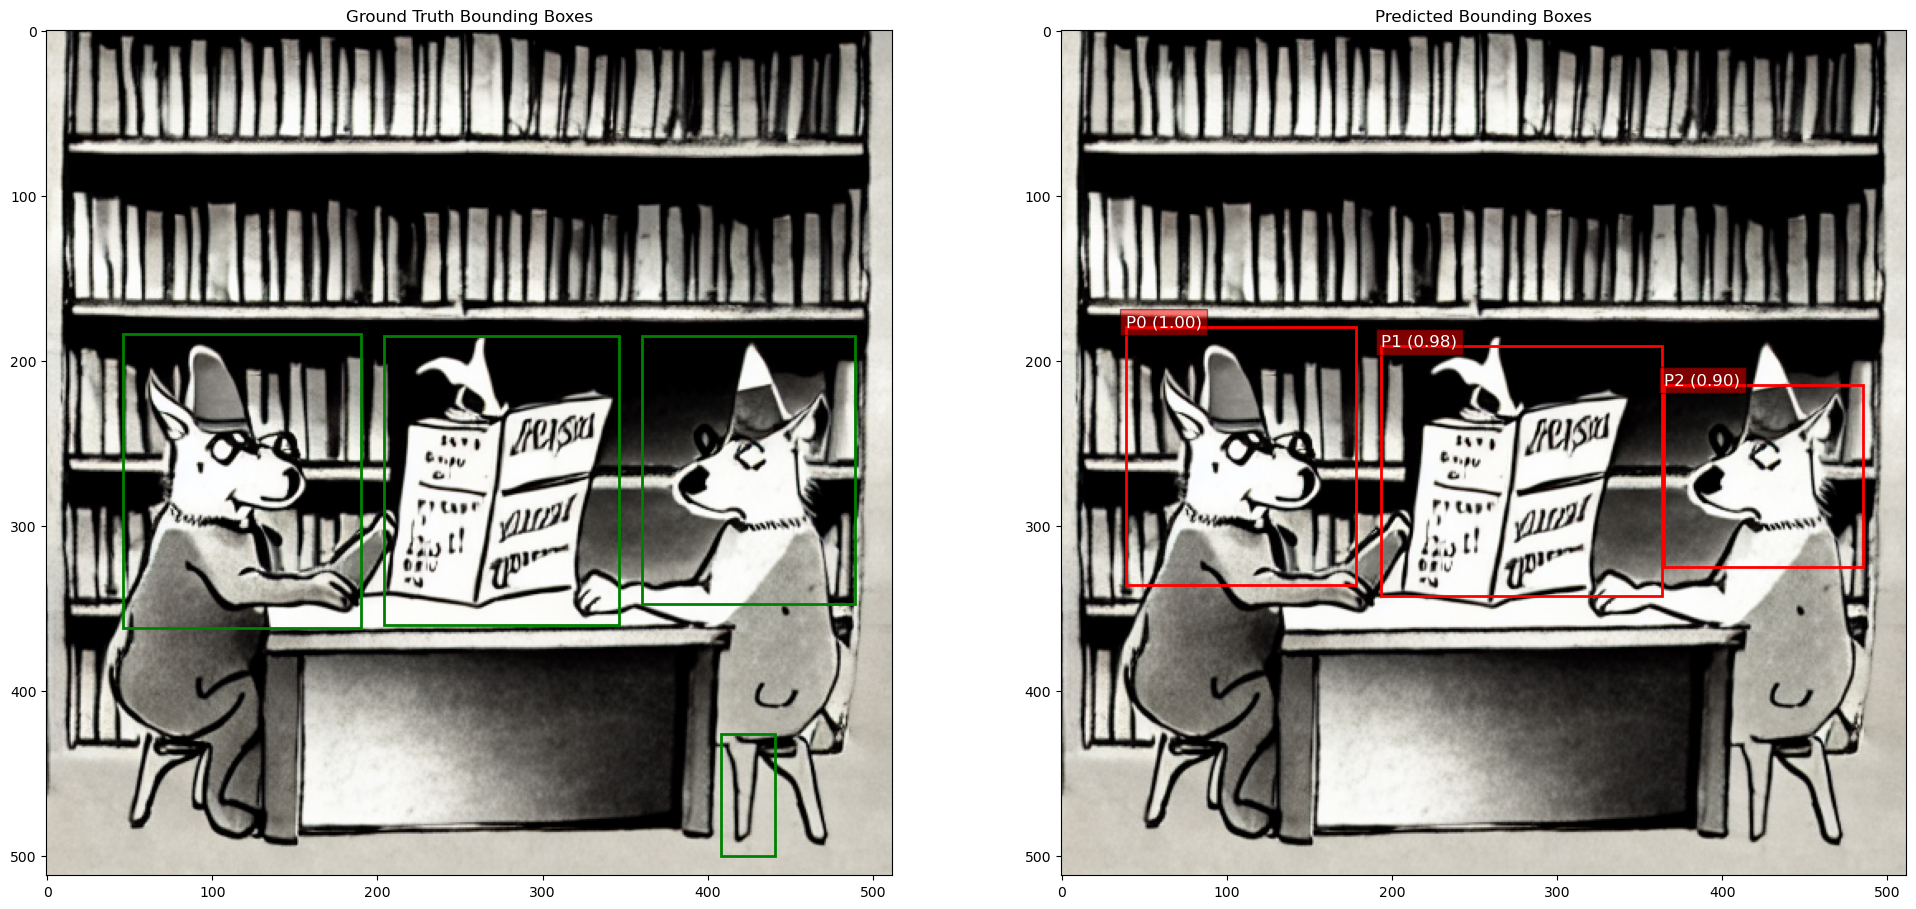


## Métriques Globales sur les 24 Images d'Éléments Totalement Nouveaux de la Deuxième Vague d'Images Générées

| **Métrique**         | **Valeur** |
|----------------------|------------|
| Précision Globale    | 0.91       |
| Rappel Global        | 0.71       |
| F1 Score Global      | 0.80       |
| Exactitude Globale   | 0.67       |
| IoU Moyen Global     | 0.67       |


In [ ]:
import os
import json
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.ops import box_iou, nms

CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.3
CONTAINMENT_THRESHOLD = 0.8

def read_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    return transform(image), image

def detect_image(model, device, image_path):
    image_tensor, original_image = read_image(image_path)
    image_tensor = image_tensor.to(device).unsqueeze(0)
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)[0]
    if 'boxes' not in output or 'scores' not in output:
        raise ValueError("Model output does not contain 'boxes' and 'scores'. Ensure you are using an object detection model.")
    pred_boxes = output['boxes']
    pred_scores = output['scores']
    high_conf_indices = pred_scores > CONFIDENCE_THRESHOLD
    pred_boxes = pred_boxes[high_conf_indices]
    pred_scores = pred_scores[high_conf_indices]
    keep = nms(pred_boxes, pred_scores, IOU_THRESHOLD)
    pred_boxes = pred_boxes[keep]
    pred_scores = pred_scores[keep]
    return pred_boxes, pred_scores, original_image

def display_image_with_boxes(image, pred_boxes, pred_scores, true_boxes):
    fig, ax = plt.subplots(1, 2, figsize=(24, 12))
    ax[0].imshow(image)
    ax[0].set_title('Ground Truth Bounding Boxes')
    for idx, box in enumerate(true_boxes):
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='g', facecolor='none')
        ax[0].add_patch(rect)
    ax[1].imshow(image)
    ax[1].set_title('Predicted Bounding Boxes')
    for idx, (box, score) in enumerate(zip(pred_boxes, pred_scores)):
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='r', facecolor='none')
        ax[1].add_patch(rect)
        ax[1].text(box[0], box[1], f'P{idx} ({score:.2f})', color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))
    plt.show()

def is_contained(pred_box, gt_box, threshold=CONTAINMENT_THRESHOLD):
    x1 = max(pred_box[0], gt_box[0])
    y1 = max(pred_box[1], gt_box[1])
    x2 = min(pred_box[2], gt_box[2])
    y2 = min(pred_box[3], gt_box[3])
    if x1 >= x2 or y1 >= y2:
        return False
    intersection_area = (x2 - x1) * (y2 - y1)
    pred_box_area = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    if pred_box_area == 0:
        return False
    containment_ratio = intersection_area / pred_box_area
    return containment_ratio >= threshold

def calculate_metrics(pred_boxes, true_boxes):
    if pred_boxes.numel() == 0 and true_boxes.numel() == 0:
        return 1, 1, 1, 1, 0, []

    if pred_boxes.numel() == 0:
        return 0, 0, 0, 0, 0, [("FN", box.tolist()) for box in true_boxes]

    if true_boxes.numel() == 0:
        return 0, 0, 0, 0, 0, [("FP", box.tolist()) for box in pred_boxes]

    ious = box_iou(pred_boxes, true_boxes)
    tp = 0
    fp = 0
    fn = 0
    details = []

    for i in range(len(pred_boxes)):
        max_iou, max_idx = ious[i].max(0) if ious[i].numel() > 0 else (torch.tensor(0), torch.tensor(0))
        contained_80 = any(is_contained(pred_boxes[i], true_boxes[j]) for j in range(len(true_boxes)))

        if max_iou >= IOU_THRESHOLD or contained_80:
            details.append(("TP: Pred Box {} -> GT Box {} with IoU {:.2f}".format(i, max_idx.item(), max_iou.item()), pred_boxes[i].tolist()))
            tp += 1
        else:
            details.append(("FP: Pred Box {} with IoU {:.2f}".format(i, max_iou.item()), pred_boxes[i].tolist()))
            fp += 1

    for j in range(len(true_boxes)):
        if ious[:, j].max().item() < IOU_THRESHOLD and not any(is_contained(pred_boxes[i], true_boxes[j]) for i in range(len(pred_boxes))):
            details.append(("FN: GT Box {} missed".format(j), true_boxes[j].tolist()))
            fn += 1

    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    accuracy = tp / (tp + fp + fn) if tp + fp + fn > 0 else 0
    mean_iou = ious.max(dim=0)[0][ious.max(dim=0)[0] >= IOU_THRESHOLD].mean().item() if tp > 0 and ious.numel() > 0 else 0

    return precision, recall, f1_score, accuracy, mean_iou, details

def process_all_images(folder_path, annotation_path, model, device):
    with open(annotation_path, 'r') as f:
        true_annotations = json.load(f)

    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    global_tp, global_fp, global_fn, global_iou_sum, global_boxes_count = 0, 0, 0, 0, 0

    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        true_boxes = [ann['coordinates'] for ann in true_annotations if ann['path_name'] == image_file]

        if len(true_boxes) == 0:
            continue

        true_boxes = torch.tensor(true_boxes, dtype=torch.float32)
        true_boxes = torch.stack([torch.tensor([x, y, x + w, y + h]) for x, y, w, h in true_boxes])

        pred_boxes, pred_scores, original_image = detect_image(model, device, image_path)
        precision, recall, f1_score, accuracy, mean_iou, details = calculate_metrics(pred_boxes.cpu(), true_boxes)

        display_image_with_boxes(original_image, pred_boxes.cpu(), pred_scores.cpu(), true_boxes)
        print(f"Image: {image_path}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1_score:.2f}, Accuracy: {accuracy:.2f}, Mean IoU: {mean_iou:.2f}")

        for detail in details:
            print(detail[0], detail[1])

        global_tp += precision * len(pred_boxes)
        global_fp += len(pred_boxes) - precision * len(pred_boxes)
        global_fn += len(true_boxes) - recall * len(true_boxes)
        global_iou_sum += mean_iou * len(pred_boxes)
        global_boxes_count += len(pred_boxes)

    global_precision = global_tp / (global_tp + global_fp) if global_tp + global_fp > 0 else 0
    global_recall = global_tp / (global_tp + global_fn) if global_tp + global_fn > 0 else 0
    global_f1_score = 2 * (global_precision * global_recall) / (global_precision + global_recall) if global_precision + global_recall > 0 else 0
    global_accuracy = global_tp / (global_tp + global_fp + global_fn) if global_tp + global_fp + global_fn > 0 else 0
    global_mean_iou = global_iou_sum / global_boxes_count if global_boxes_count > 0 else 0
    print(f"\nGlobal Metrics across all test images:")
    print(f"Global Precision: {global_precision:.2f}")
    print(f"Global Recall: {global_recall:.2f}")
    print(f"Global F1 Score: {global_f1_score:.2f}")
    print(f"Global Accuracy: {global_accuracy:.2f}")
    print(f"Global Mean IoU: {global_mean_iou:.2f}")

folder_path = './Data/test/'
annotation_path = "./Data/test/annotations_test.json"
process_all_images(folder_path, annotation_path, model, device)


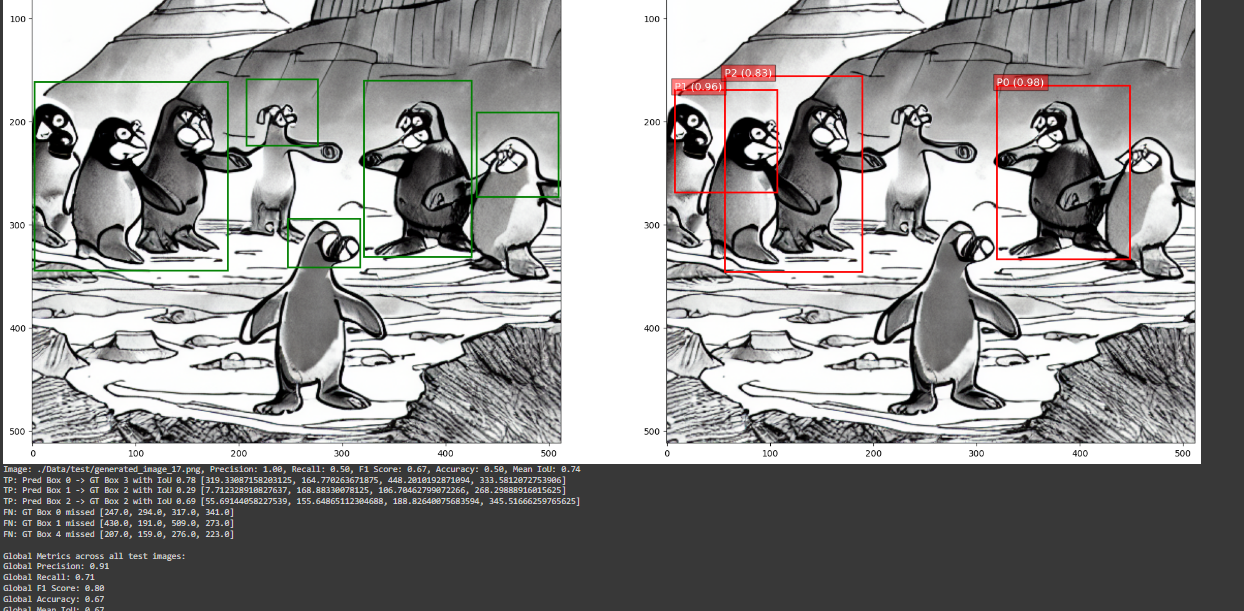

## Métriques Globales sur les 24 Images d'Éléments Totalement Nouveaux de la Deuxième Vague d'Images Générées

| **Métrique**         | **Valeur** |
|----------------------|------------|
| Précision Globale    | 0.91       |
| Rappel Global        | 0.71       |
| F1 Score Global      | 0.80       |
| Exactitude Globale   | 0.67       |
| IoU Moyen Global     | 0.67       |


#Tester Une image

In [ ]:
import os
import json
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.ops import box_iou, nms

def read_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    return transform(image), image

def detect_image(model, device, image_path, confidence_threshold=0.3, iou_threshold=0.3):
    image_tensor, original_image = read_image(image_path)
    image_tensor = image_tensor.to(device).unsqueeze(0)

    model.eval()
    with torch.no_grad():
        output = model(image_tensor)[0]

    pred_boxes = output['boxes']
    pred_scores = output['scores']
    high_conf_indices = pred_scores > confidence_threshold
    pred_boxes = pred_boxes[high_conf_indices]
    pred_scores = pred_scores[high_conf_indices]

    keep = nms(pred_boxes, pred_scores, iou_threshold)
    pred_boxes = pred_boxes[keep]
    pred_scores = pred_scores[keep]

    return pred_boxes, pred_scores, original_image

def display_image_with_boxes(image, pred_boxes, pred_scores, true_boxes):
    fig, ax = plt.subplots(1, 2, figsize=(24, 12))

    ax[0].imshow(image)
    ax[0].set_title('Ground Truth Bounding Boxes')
    for idx, box in enumerate(true_boxes):
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                 linewidth=2, edgecolor='g', facecolor='none')
        ax[0].add_patch(rect)
        ax[0].text(box[0], box[1], f'GT{idx}', color='white', fontsize=12,
                   bbox=dict(facecolor='green', alpha=0.5))

    ax[1].imshow(image)
    ax[1].set_title('Predicted Bounding Boxes')
    for idx, (box, score) in enumerate(zip(pred_boxes, pred_scores)):
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax[1].add_patch(rect)
        ax[1].text(box[0], box[1], f'P{idx} ({score:.2f})', color='white', fontsize=12,
                   bbox=dict(facecolor='red', alpha=0.5))
    plt.show()

def is_contained(pred_box, gt_box, threshold=0.8):

    x1 = max(pred_box[0], gt_box[0])
    y1 = max(pred_box[1], gt_box[1])
    x2 = min(pred_box[2], gt_box[2])
    y2 = min(pred_box[3], gt_box[3])

    if x1 >= x2 or y1 >= y2:
        return False

    intersection_area = (x2 - x1) * (y2 - y1)
    pred_box_area = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])

    if pred_box_area == 0:
        return False

    containment_ratio = intersection_area / pred_box_area

    return containment_ratio >= threshold


def calculate_metrics(pred_boxes, true_boxes, iou_threshold=0.3):
    ious = box_iou(pred_boxes, true_boxes)
    decision_details = []
    details = []

    tp = 0
    fp = 0
    fn = 0
    for i in range(len(pred_boxes)):
        max_iou, max_idx = ious[i].max(0)
        is_contained_80 = any(is_contained(pred_boxes[i], true_boxes[j]) for j in range(len(true_boxes)))

        if max_iou >= iou_threshold or is_contained_80:
            decision_details.append((f"TP: Pred Box {i} -> GT Box {max_idx} with IoU {max_iou:.2f}", pred_boxes[i].tolist()))
            tp += 1
        else:
            decision_details.append((f"FP: Pred Box {i} with IoU {max_iou:.2f}", pred_boxes[i].tolist()))
            fp += 1

    for j in range(len(true_boxes)):
        if ious[:, j].max().item() < iou_threshold and not any(is_contained(pred_boxes[i], true_boxes[j]) for i in range(len(pred_boxes))):
            decision_details.append((f"FN: GT Box {j} missed", true_boxes[j].tolist()))
            fn += 1

    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    accuracy = tp / (tp + fp + fn) if tp + fp + fn > 0 else 0
    mean_iou = ious.max(dim=0)[0][ious.max(dim=0)[0] >= iou_threshold].mean().item() if tp > 0 else 0

    return precision, recall, f1_score, accuracy, mean_iou, details, decision_details

def process_all_images(folder_path, annotation_path, model, device, confidence_threshold=0.3, iou_threshold=0.3):
    with open(annotation_path, 'r') as f:
        true_annotations = json.load(f)

    image_file = 'generated_image_1.png'
    image_path = os.path.join(folder_path, image_file)
    true_boxes = [ann['coordinates'] for ann in true_annotations if ann['path_name'] == image_file]

    if not true_boxes:
        print("No annotations found for the image.")
        return

    true_boxes = torch.tensor(true_boxes, dtype=torch.float32)
    true_boxes = torch.stack([torch.tensor([x, y, x + w, y + h]) for x, y, w, h in true_boxes])

    pred_boxes, pred_scores, original_image = detect_image(model, device, image_path, confidence_threshold, iou_threshold)
    precision, recall, f1_score, accuracy, mean_iou, details, decision_details = calculate_metrics(pred_boxes.cpu(), true_boxes)

    display_image_with_boxes(original_image, pred_boxes.cpu(), pred_scores.cpu(), true_boxes)
    print(f"Image: {image_path}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1_score:.2f}, Accuracy: {accuracy:.2f}, Mean IoU: {mean_iou:.2f}")

    for detail in decision_details:
        print(detail[0], detail[1])

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

folder_path = './Data/test/'
annotation_path = "./Data/test/annotations_test.json"

process_all_images(folder_path, annotation_path, model, device)